# Use Case : churn rate

In [119]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [43]:
transactions = pd.read_csv(os.path.join("data", "client_history.csv")).drop(columns="Unnamed: 0")
transactions["date_order"] = pd.to_datetime(transactions["date_order"])

In [44]:
transactions.head()

,client_id,branch_id,date_order,order_invoice_delta,sales_net,quantity,past_lifetime_value,last_order,time_since_last,age,sales_net_growth_rate,churned
0,585799,5274,2017-09-25,0,753.348900,53,1407.965700,0,3.0,3,0.15,0
1,585799,5274,2017-09-27,0,151.666600,16,1559.632300,0,2.0,5,-0.80,0
2,585799,5274,2017-09-28,1,436.930989,975,1996.563289,0,1.0,6,1.88,0
3,585799,5274,2017-09-29,3,134.716980,41,2131.280269,0,1.0,7,-0.69,0
4,585799,5274,2017-10-04,0,761.844180,30,2893.124449,0,5.0,12,4.66,0


## 1. Define churn

In [45]:
## Integrated to the preprocessing script

## 2. Real churn rate analysis

In [27]:
# After how many transactions did a ClientCo client churned ?
transactions.churned.value_counts()

0    681210
1       884
Name: churned, dtype: int64

In [107]:
clients = transactions.drop(columns=['quantity', 'last_order', 'date_order']).groupby(
                              by=["client_id", "branch_id"]).agg(max_delay = ('order_invoice_delta','max'),
                                                                   average_sales_net = ('sales_net','mean'), 
                                                                   lifetime_value = ('past_lifetime_value','max'), 
                                                                   avg_time_between_orders = ('time_since_last','mean'), 
                                                                   lifespan_days = ('age','max'), 
                                                                   avg_growth_rate = ('sales_net_growth_rate','mean') , 
                                                                   churned = ('churned','max'))
clients.reset_index(inplace=True)
clients.replace([np.inf, -np.inf], np.nan, inplace=True)
clients.dropna(inplace=True)


In [108]:
clients

,client_id,branch_id,max_delay,average_sales_net,lifetime_value,avg_time_between_orders,lifespan_days,avg_growth_rate,churned
1,18,6654,7,3822.830000,11284.494600,35.000000,35,-0.490000,0
2,373,228,8,257.665298,2354.936683,71.222222,641,3.582222,0
3,549,7993,123,865.219627,2723.633535,72.500000,145,-0.120000,0
4,753,364,1,270.611578,1221.216657,172.000000,688,0.407500,0
6,1066,3550,59,1270.203272,243004.221117,0.910995,174,1.957173,0
...,...,...,...,...,...,...,...,...,...
19091,2273653,4108,62,962.116656,25906.698242,11.192308,291,1.990000,0
19093,2274019,3353,7,408.120855,2473.932287,138.000000,552,0.120000,0
19094,2274156,4424,28,976.245912,72806.863095,9.675676,716,2.482568,0
19095,2274188,1857,14,1462.305592,4605.738776,164.666667,494,7.236667,0


<AxesSubplot:xlabel='churned', ylabel='lifetime_value'>

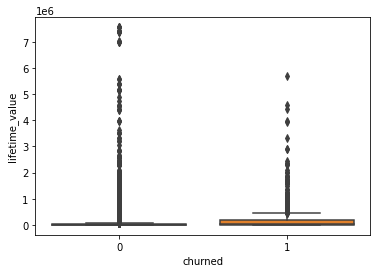

In [86]:
sns.boxplot(data=clients, y="lifetime_value", x="churned")

<AxesSubplot:xlabel='churned', ylabel='lifetime_value'>

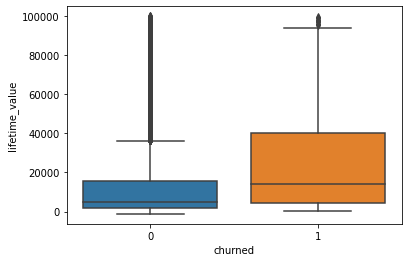

In [87]:
sns.boxplot(data=clients[clients.lifetime_value<10**5], y="lifetime_value", x="churned")

<AxesSubplot:xlabel='churned', ylabel='max_delay'>

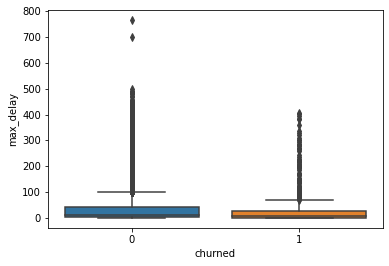

In [88]:
sns.boxplot(data=clients, y="max_delay", x="churned")

In [89]:
clients.churned.mean()

0.049776007964161276

In [106]:
np.all(np.isfinite(clients))

False

## 3. Churn prediction model

In [110]:
X = clients.set_index("client_id").drop(columns=["churned"])
y = clients.set_index("client_id").loc[:,["churned"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [111]:
print(X_train.shape)
print(X_test.shape)

(12795, 7)
(3199, 7)


In [114]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [116]:
X_test

array([[-7.54230696e-01,  3.84064912e-01,  1.11345485e-01, ...,
        -3.11565541e-01, -4.78567740e-01,  1.07042390e-03],
       [ 4.62361817e-01, -1.44196800e-01, -3.09512016e-01, ...,
        -5.11569718e-01, -2.76560993e-01,  1.07042390e-03],
       [-1.11792848e+00, -5.69740956e-01, -3.81522958e-01, ...,
         1.51204134e+00, -6.08156973e-01,  1.07042390e-03],
       ...,
       [ 8.98486975e-01, -3.78979783e-01, -1.62868861e-01, ...,
        -1.94251712e-01,  4.66671375e-01,  1.07042390e-03],
       [-1.15496213e-01, -5.69740956e-01, -4.83957821e-01, ...,
        -2.39752860e-01, -1.27516038e+00,  1.07042390e-03],
       [-1.59057951e+00, -3.34957973e-01, -4.17373821e-01, ...,
         4.28932012e-01,  2.57041732e-01,  1.07042390e-03]])

In [117]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

GradientBoostingClassifier()

In [118]:
model.score(X_test, y_test)

0.9756173804313848

In [120]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

<AxesSubplot:>

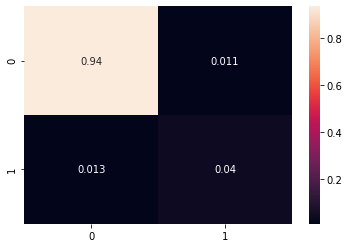

In [125]:
sns.heatmap(confusion_matrix(y_pred, y_test, normalize = 'all'),annot = True)

<AxesSubplot:>

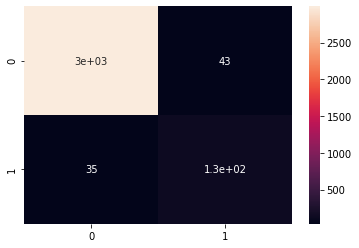

In [126]:
sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)